In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white')

%matplotlib inline

In [160]:
# read data
data = pd.read_csv(
    'data/credit_train_label.csv'
)

In [161]:
data.drop('X', axis=1, inplace=True)

In [162]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

In [163]:
# Windsor
for feature in X.columns:
    X.loc[X[feature] > X[feature].quantile(0.99), feature] = X[feature].quantile(0.999)

In [164]:
# separate test and train data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=433)

In [165]:
monthly_income_median = X_train['MonthlyIncome'].median()
number_of_dependents = X_train['NumberOfDependents'].median()

In [166]:
X_train['MonthlyIncome'].fillna(monthly_income_median, inplace=True)
X_train['NumberOfDependents'].fillna(number_of_dependents, inplace=True)

X_test['MonthlyIncome'].fillna(monthly_income_median, inplace=True)
X_test['NumberOfDependents'].fillna(number_of_dependents, inplace=True)

/home/pfcor/miniconda3/envs/kaggle_fia/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [167]:
# # scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train) # fitted on train data only

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [168]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

sm = SMOTE(random_state=433)
sm = RandomOverSampler(random_state=433)
X_train, y_train = sm.fit_sample(X_train, y_train)
# X_res, y_res = ros.fit_sample(X_train, y_train)

In [169]:
from sklearn.ensemble import GradientBoostingClassifier

params = {
    'subsample': 1,
    'n_estimators': 300,
    'min_samples_split': 2,
    'max_depth': 3,
    'learning_rate': 0.1,
    'random_state': 42
}


clf = GradientBoostingClassifier(**params)


clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(confusion_matrix(y_test, y_hat))
print()
print(classification_report(y_test, y_hat))
print()
print(roc_auc_score(y_test, y_probs[:,1]))

[[9547 2138]
 [ 204  611]]

             precision    recall  f1-score   support

          0       0.98      0.82      0.89     11685
          1       0.22      0.75      0.34       815

avg / total       0.93      0.81      0.86     12500


0.8572924755401896


In [79]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.01, 'random_state': 42}
clf = GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(confusion_matrix(y_test, y_hat))
print()
print(classification_report(y_test, y_hat))
print()
print(roc_auc_score(y_test, y_probs[:,1]))

[[11591    94]
 [  677   138]]

             precision    recall  f1-score   support

          0       0.94      0.99      0.97     11685
          1       0.59      0.17      0.26       815

avg / total       0.92      0.94      0.92     12500


0.8330667233698491


In [110]:
tuned_parameters = {'n_estimators': [10, 100, 300, 600],
                     'max_depth' : [3, 10, 15],
                     'min_samples_split': [2, 6, 10],
                     'learning_rate': [0.001, 0.01, 0.1, 1], 
                     'subsample': [0.5, 1]}

In [112]:
%%time

from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf = GradientBoostingClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = tuned_parameters, n_iter = 5, cv = 3, verbose=2, random_state=433, n_jobs = -1, scoring='roc_auc')

# Fit the random search model
clf_random.fit(X_train, y_train)



Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] subsample=1, n_estimators=100, min_samples_split=2, max_depth=15, learning_rate=0.01 
[CV] subsample=1, n_estimators=100, min_samples_split=2, max_depth=15, learning_rate=0.01 
[CV] subsample=1, n_estimators=100, min_samples_split=2, max_depth=15, learning_rate=0.01 
[CV] subsample=1, n_estimators=300, min_samples_split=10, max_depth=3, learning_rate=1 
[CV]  subsample=1, n_estimators=300, min_samples_split=10, max_depth=3, learning_rate=1, total=  23.9s
[CV] subsample=1, n_estimators=300, min_samples_split=10, max_depth=3, learning_rate=1 
[CV]  subsample=1, n_estimators=300, min_samples_split=10, max_depth=3, learning_rate=1, total=  21.6s
[CV] subsample=1, n_estimators=300, min_samples_split=10, max_depth=3, learning_rate=1 
[CV]  subsample=1, n_estimators=300, min_samples_split=10, max_depth=3, learning_rate=1, total=  20.8s
[CV] subsample=1, n_estimators=10, min_samples_split=10, max_depth=3, learning_rate=1 
[CV]  s

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.5min finished


CPU times: user 1.24 s, sys: 133 ms, total: 1.37 s
Wall time: 6min 32s


In [113]:
clf_random.best_params_

{'subsample': 1,
 'n_estimators': 10,
 'min_samples_split': 10,
 'max_depth': 3,
 'learning_rate': 1}

In [114]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'subsample': 1,
 'n_estimators': 10,
 'min_samples_split': 10,
 'max_depth': 3,
 'learning_rate': 1
         }


clf = GradientBoostingClassifier(**params)


clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(confusion_matrix(y_test, y_hat))
print()
print(classification_report(y_test, y_hat))
print()
print(roc_auc_score(y_test, y_probs[:,1]))

[[11504   181]
 [  638   177]]

             precision    recall  f1-score   support

          0       0.95      0.98      0.97     11685
          1       0.49      0.22      0.30       815

avg / total       0.92      0.93      0.92     12500


0.8186213776248192


In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=)

clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(confusion_matrix(y_test, y_hat))
print()
print(classification_report(y_test, y_hat))
print()
print(roc_auc_score(y_test, y_probs[:,1]))

[[11548   137]
 [  648   167]]

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     11685
          1       0.55      0.20      0.30       815

avg / total       0.92      0.94      0.92     12500


0.844091397129664


In [14]:
feat_importance = sorted(list(zip(clf.feature_importances_, X.columns)))
feat_importance

[(0.0372643673608342, 'NumberRealEstateLoansOrLines'),
 (0.04515270459888966, 'NumberOfDependents'),
 (0.0509481126641049, 'NumberOfTime60.89DaysPastDueNotWorse'),
 (0.05132629924640461, 'NumberOfTime30.59DaysPastDueNotWorse'),
 (0.08701260190180024, 'NumberOfTimes90DaysLate'),
 (0.09131455123458261, 'NumberOfOpenCreditLinesAndLoans'),
 (0.13188889184762898, 'age'),
 (0.14457131457051867, 'MonthlyIncome'),
 (0.17144179403855564, 'DebtRatio'),
 (0.1890793625366806, 'RevolvingUtilizationOfUnsecuredLines')]

# feature engineering


In [55]:
data2 = data.copy()

In [99]:
data.head().T

,0,1,2,3,4
X,1.000000,2.000000,3.000000,4.00000,5.000000
SeriousDlqin2yrs,1.000000,0.000000,0.000000,0.00000,0.000000
RevolvingUtilizationOfUnsecuredLines,0.766127,0.957151,0.658180,0.23381,0.907239
age,45.000000,40.000000,38.000000,30.00000,49.000000
NumberOfTime30.59DaysPastDueNotWorse,2.000000,0.000000,1.000000,0.00000,1.000000
DebtRatio,0.802982,0.121876,0.085113,0.03605,0.024926
MonthlyIncome,9120.000000,2600.000000,3042.000000,3300.00000,63588.000000
NumberOfOpenCreditLinesAndLoans,13.000000,4.000000,2.000000,5.00000,7.000000
NumberOfTimes90DaysLate,0.000000,0.000000,1.000000,0.00000,0.000000
NumberRealEstateLoansOrLines,6.000000,0.000000,0.000000,0.00000,1.000000


In [100]:
data['RevolvingUtilizationOfUnsecuredLinesGreaterThan1'] = (data.RevolvingUtilizationOfUnsecuredLines > 1).astype(int)

In [101]:
data.drop('RevolvingUtilizationOfUnsecuredLines', axis=1, inplace=True)

In [102]:
data['age'] = pd.get_dummies(pd.qcut(data.age,4))

In [103]:
data.drop('age', axis=1, inplace=True)

In [ ]:
data3.to_csv('data/data')

In [64]:
x = pd.qcut(data2.age,4)

In [66]:
pd.get_dummies(x)

,"(20.999, 41.0]","(41.0, 52.0]","(52.0, 63.0]","(63.0, 107.0]"
0,0,1,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0
5,0,0,0,1
6,0,0,1,0
7,1,0,0,0
8,1,0,0,0
9,0,0,1,0


In [ ]:
data2['age_category'] = x

In [42]:
data.loc[data.RevolvingUtilizationOfUnsecuredLines < 0.5, 'SeriousDlqin2yrs'].mean()

0.028055225078161748

In [48]:
pd.crosstab(x, y)

SeriousDlqin2yrs,0,1
RevolvingUtilizationOfUnsecuredLines,,
"(-0.001, 0.00284]",4861,139
"(0.00284, 0.0189]",4927,73
"(0.0189, 0.0436]",4916,84
"(0.0436, 0.0851]",4909,91
"(0.0851, 0.157]",4881,119
"(0.157, 0.275]",4832,168
"(0.275, 0.449]",4732,268
"(0.449, 0.712]",4587,413
"(0.712, 0.987]",4172,828


In [ ]:
data['RevolvingUtilizationOfUnsecuredLinesGreaterThat']

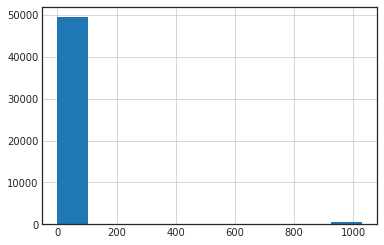

In [34]:
X.RevolvingUtilizationOfUnsecuredLines.hist()

In [11]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train) # fitted on train data only

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

sm = SMOTE(random_state=433)
# ros = RandomOverSampler(random_state=433)
X_res, y_res = sm.fit_sample(X_train, y_train)
# X_res, y_res = ros.fit_sample(X_train, y_train)

In [13]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(5,5,))

mlp.fit(X_train, y_train)
y_hat = mlp.predict(X_test)
y_probs = mlp.predict_proba(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(confusion_matrix(y_test, y_hat))
print()
print(classification_report(y_test, y_hat))
print()
print(roc_auc_score(y_test, y_probs[:,1]))

[[11538   147]
 [  635   180]]

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     11685
          1       0.55      0.22      0.32       815

avg / total       0.92      0.94      0.92     12500


0.8294525780259419


In [14]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.01, 'random_state': 42}
clf = GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(confusion_matrix(y_test, y_hat))
print()
print(classification_report(y_test, y_hat))
print()
print(roc_auc_score(y_test, y_probs[:,1]))

[[11585   100]
 [  665   150]]

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     11685
          1       0.60      0.18      0.28       815

avg / total       0.92      0.94      0.92     12500


0.8570179376317495


In [13]:
tuned_parameters = [{'hidden_layer_sizes': [(1,), (10,), (5,5,)],
                     'activation' : ['logistic', 'relu'],
                     'learning_rate': ['constant', 'adaptive'],
                     'alpha': [0.01, 0.1]}]

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(MLPClassifier(), tuned_parameters, cv=3)
clf.fit(X_train, y_train)

/home/pfcor/miniconda3/envs/kaggle_fia/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/pfcor/miniconda3/envs/kaggle_fia/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
